Test part of the code to debug collecting data and preprocessing

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import shutil

Load Original image

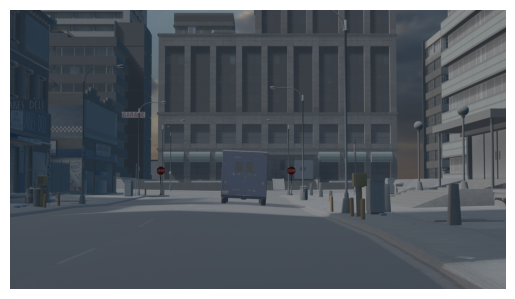

In [2]:
image_base = cv2.imread("C:\\Users\\SKG\\GitHub\\3D_ComputerVision\\blender_augmentation\\models\\data\\images\\image_001_0001.png")
image_base = cv2.cvtColor(image_base, cv2.COLOR_BGR2RGB)
plt.axis("off");
plt.imshow(image_base);

Load image with turned off environment

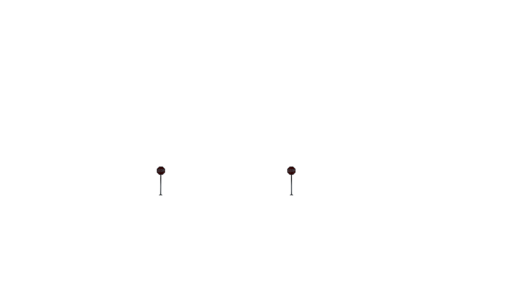

In [3]:
image_label = cv2.imread("C:\\Users\\SKG\\GitHub\\3D_ComputerVision\\blender_augmentation\\models\\data\\labels\\image_001_0001_label.png", cv2.IMREAD_UNCHANGED)
image_label = cv2.cvtColor(image_label, cv2.COLOR_BGRA2RGBA)
plt.axis("off");
plt.imshow(image_label);

Extract contours of stop signs

In [4]:
# Извлечение альфа-канала
alpha_channel = image_label[:, :, 3]
# Бинаризация маски
_, mask = cv2.threshold(alpha_channel, 1, 255, cv2.THRESH_BINARY)

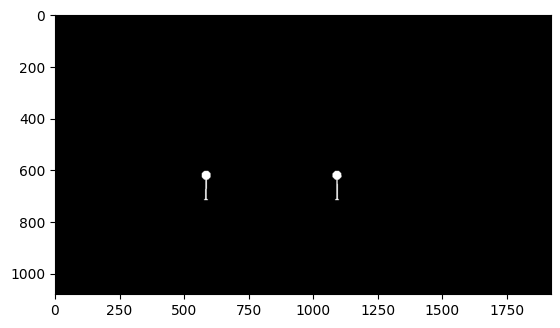

In [5]:
plt.imshow(mask, cmap='gray')

In [6]:
# Поиск контуров
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

Euclidean Distance: 3.2359187961910725


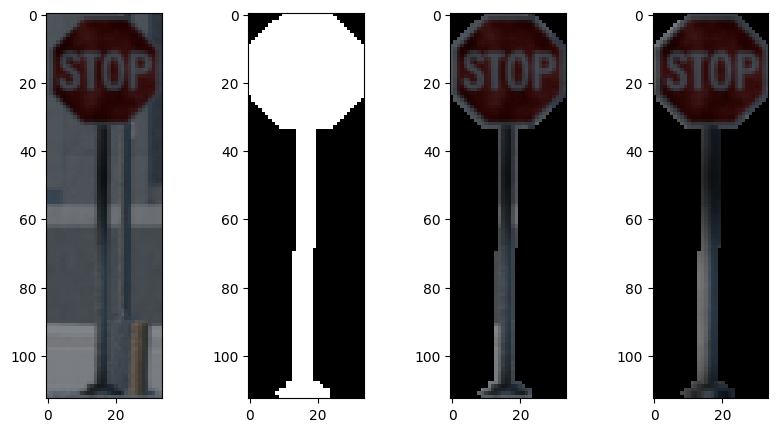

In [7]:
x, y, w, h = cv2.boundingRect(contours[1])
body = image_base[y:y+h,x:x+w]
body_label = image_label[y:y+h,x:x+w]
body_mask = mask[y:y+h,x:x+w]

masked_image = cv2.bitwise_and(body[:, :, :3], body[:, :, :3], mask=body_mask)
masked_image_label = cv2.bitwise_and(body_label[:, :, :3], body_label[:, :, :3], mask=body_mask)
mean_value_image = cv2.mean(masked_image[:, :, :3], mask=body_mask)
mean_value_label = cv2.mean(masked_image_label[:, :, :3], mask=body_mask)


# Method 1: Calculate Absolute Difference
# Method 2: Calculate Euclidean Distance
distance = np.linalg.norm(np.array(mean_value_image[:3]) - np.array(mean_value_label[:3]))
print(f"Euclidean Distance: {distance}")

fig, ax = plt.subplots(1, 4, figsize=(10, 5))
ax[0].imshow(body)
ax[1].imshow(body_mask, cmap='gray')
ax[2].imshow(masked_image, cmap='gray')
ax[3].imshow(masked_image_label, cmap='gray')


(58.80370624571036, 46.051475634866165, 49.15030885380919, 0.0)
(53.822656776803775, 43.155091031692514, 46.93459204315577, 0.0)


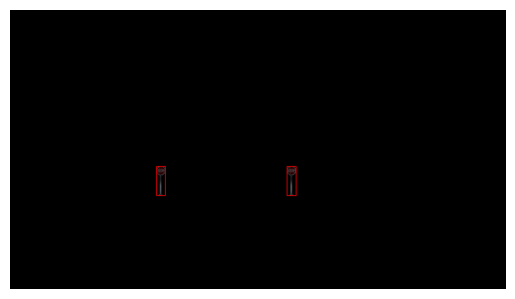

In [8]:
# Рисуем bounding box
output_image = image_label[:, :, :3].copy()  # Убираем альфа-канал

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)

    body = image_base[y:y+h,x:x+w]
    body_mask = mask[y:y+h,x:x+w]
    # Применение маски
    masked_image = cv2.bitwise_and(body[:, :, :3], body[:, :, :3], mask=body_mask)
    # Среднее значение пикселей в маске
    mean_value = cv2.mean(body[:, :, :3], mask=body_mask)
    print(mean_value)


    cv2.rectangle(output_image, (x, y), (x + w, y + h), (255, 0, 0), 2)

# Отображение результата
plt.imshow(output_image)
plt.axis('off')
plt.show()

Загрузим данные о изображениях и лейблах к ним

In [107]:
images_path = sorted(os.listdir("C:\\Users\\SKG\\GitHub\\3D_ComputerVision\\blender_augmentation\\models\\data\\images"))
labels_path = sorted(os.listdir("C:\\Users\\SKG\\GitHub\\3D_ComputerVision\\blender_augmentation\\models\\data\\labels"))

Создание словаря с данными об изображении и аннотации

In [108]:
data = {}
data["info"] = {'year': '2024', 'version': '1', 'description': 'Stop Sign Dataset', 'contributor': 'Kirill Starodubov', 'url': None, 'date_created': '2024-12-11'}
data["lincenses"] = [{'id': 1, 'url': 'https://creativecommons.org/licenses/by/4.0/', 'name': 'CC BY 4.0'}]
data["images"]=[]
data["annotations"]=[]
data["categories"]=[{'id': 0, 'name': 'stop-sign'}]
data

{'info': {'year': '2024',
  'version': '1',
  'description': 'Stop Sign Dataset',
  'contributor': 'Kirill Starodubov',
  'url': None,
  'date_created': '2024-12-11'},
 'lincenses': [{'id': 1,
   'url': 'https://creativecommons.org/licenses/by/4.0/',
   'name': 'CC BY 4.0'}],
 'images': [],
 'annotations': [],
 'categories': [{'id': 0, 'name': 'stop-sign'}]}

Создание словаря с данными об изображении и аннотации

In [109]:
counter = 0
# image_path_upd = []

for i in range(len(images_path)):
    # Определение пути к файлам
    image_path = "C:\\Users\\SKG\\GitHub\\3D_ComputerVision\\blender_augmentation\\models\\data\\images\\" + images_path[i]
    label_path = "C:\\Users\\SKG\\GitHub\\3D_ComputerVision\\blender_augmentation\\models\\data\\labels\\" + labels_path[i]
    
    # Открытие файлов с cv2
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    label = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)
    label = cv2.cvtColor(label, cv2.COLOR_BGRA2RGBA)
        
    # Извлечение альфа-канала
    alpha_channel = label[:, :, 3]
    # Бинаризация маски
    _, mask = cv2.threshold(alpha_channel, 1, 255, cv2.THRESH_BINARY)

    # Поиск контуров
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Рисуем bounding box
    output_image = image[:, :, :3].copy()  # Убираем альфа-канал

    flag_contour = False

    for j, contour in enumerate(contours):
        # ---------------------------------------------------------------
        x, y, w, h = cv2.boundingRect(contour)
        body = image[y:y+h,x:x+w]
        body_label = label[y:y+h,x:x+w]
        body_mask = mask[y:y+h,x:x+w]

        masked_image = cv2.bitwise_and(body[:, :, :3], body[:, :, :3], mask=body_mask)
        masked_image_label = cv2.bitwise_and(body_label[:, :, :3], body_label[:, :, :3], mask=body_mask)
        mean_value_image = cv2.mean(masked_image[:, :, :3], mask=body_mask)
        mean_value_label = cv2.mean(masked_image_label[:, :, :3], mask=body_mask)

        distance = np.linalg.norm(np.array(mean_value_image[:3]) - np.array(mean_value_label[:3]))
        
        if distance < 30:
            data["annotations"].append({"id": counter, "image_id": i, "category_id": 0, "bbox": [x, y, w, h], "area": w * h, "segmentation": [], "iscrowd": 0})
            counter += 1
            flag_contour = True
        
    if flag_contour:
        data["images"].append({"id": i, 'license': 1, "file_name": images_path[i], "height": image.shape[0], "width": image.shape[1], 'date_captured': None})
        # image_path_upd.append(image_path[i])
               
        # ---------------------------------------------------------------



In [110]:
# Сохранение в файл
with open("./models/annotations.json", "w") as f:
    json.dump(data, f, indent=4)

Test

In [111]:
data["annotations"][73]

{'id': 73,
 'image_id': 45,
 'category_id': 0,
 'bbox': [609, 582, 46, 154],
 'area': 7084,
 'segmentation': [],
 'iscrowd': 0}

In [112]:
from collections import defaultdict
# Grouping annotations by image_id
annotations_by_image = defaultdict(list)
annotations_by_image_upd = defaultdict(list)

# Fill the dictionary
for annotation in data["annotations"]:
    annotations_by_image[annotation['image_id']].append(annotation)

for i, k in enumerate(annotations_by_image.keys()):
    annotations_by_image_upd[i] = annotations_by_image[k]

In [113]:
image_id_to_find = 72
found_annotations = annotations_by_image_upd[image_id_to_find]
found_annotations

[{'id': 104,
  'image_id': 73,
  'category_id': 0,
  'bbox': [306, 556, 61, 201],
  'area': 12261,
  'segmentation': [],
  'iscrowd': 0}]

Сделаем датасет с bbox

In [114]:
for i in range(len(data["images"])):
    image_path = os.path.join("./models/data/images/", data["images"][i]["file_name"])
    found_annotations = annotations_by_image_upd[i]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for d in found_annotations:
        x, y, w, h = d["bbox"]
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
    ground_name = data["images"][i]["file_name"].split(".")[0] + "_ground.png"
    plt.imsave(os.path.join("./models/data/ground/", ground_name), image)


Проверка работоспособности аннотации

In [222]:
# Загрузка в файл
with open("models/annotations.json") as file:
    data = json.load(file)

./models/data/images/image_001_0074.png
./models/data/labels/image_001_0074_label.png


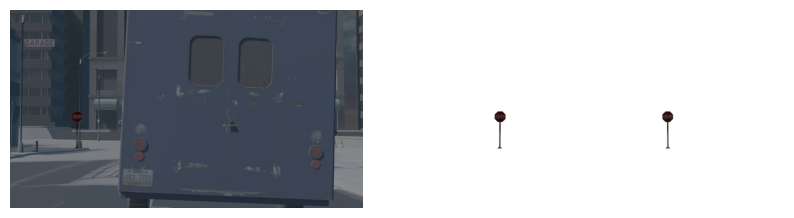

In [115]:
im_path = data["images"][73]["file_name"]
image_path = "./models/data/images/" + im_path
print(image_path)
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# plt.axis("off")
# plt.imshow(image)

lab_path = "./models/data/labels/" + im_path.split(".")[0] + "_label.png"
print(lab_path)
image_label = cv2.imread(lab_path, cv2.IMREAD_UNCHANGED)
image_label = cv2.cvtColor(image_label, cv2.COLOR_BGRA2RGBA)
# plt.imshow(image_label)

fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].imshow(image);
ax[0].axis("off");
ax[1].imshow(image_label);
ax[1].axis("off");


In [116]:
image_id_to_find = 73
found_annotations = annotations_by_image_upd[image_id_to_find]
found_annotations

[{'id': 105,
  'image_id': 74,
  'category_id': 0,
  'bbox': [334, 555, 62, 203],
  'area': 12586,
  'segmentation': [],
  'iscrowd': 0}]

In [117]:
output_image = image.copy()

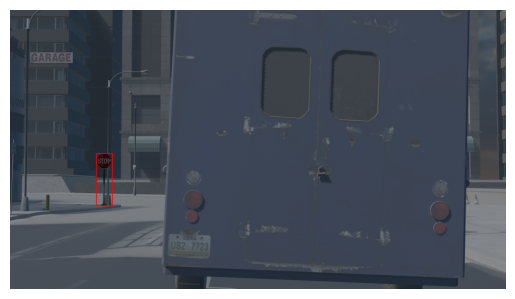

In [118]:
for e in found_annotations:
    x,y,w,h = e["bbox"]
    cv2.rectangle(output_image, (x, y), (x + w, y + h), (255, 0, 0), 2)

plt.imshow(output_image)
plt.axis("off")
plt.show()

Разобьём датасет на 3 части: train, val, test

In [119]:
train_annotations = {}
train_annotations["info"] = {'year': '2024', 'version': '1', 'description': 'Stop Sign Dataset', 'contributor': 'Kirill Starodubov', 'url': None, 'date_created': '2024-12-11'}
train_annotations["lincenses"] = [{'id': 1, 'url': 'https://creativecommons.org/licenses/by/4.0/', 'name': 'CC BY 4.0'}]
train_annotations["images"]=[]
train_annotations["annotations"]=[]
train_annotations["categories"]=[{'id': 0, 'name': 'stop_sign'}]

valid_annotations = {}
valid_annotations["info"] = {'year': '2024', 'version': '1', 'description': 'Stop Sign Dataset', 'contributor': 'Kirill Starodubov', 'url': None, 'date_created': '2024-12-11'}
valid_annotations["lincenses"] = [{'id': 1, 'url': 'https://creativecommons.org/licenses/by/4.0/', 'name': 'CC BY 4.0'}]
valid_annotations["images"]=[]
valid_annotations["annotations"]=[]
valid_annotations["categories"]=[{'id': 0, 'name': 'stop_sign'}]

test_annotations = {}
test_annotations["info"] = {'year': '2024', 'version': '1', 'description': 'Stop Sign Dataset', 'contributor': 'Kirill Starodubov', 'url': None, 'date_created': '2024-12-11'}
test_annotations["lincenses"] = [{'id': 1, 'url': 'https://creativecommons.org/licenses/by/4.0/', 'name': 'CC BY 4.0'}]
test_annotations["images"]=[]
test_annotations["annotations"]=[]
test_annotations["categories"]=[{'id': 0, 'name': 'stop_sign'}]


In [120]:
images_path = sorted(os.listdir("./models/data/images"))

In [121]:
# Shuffle and split
indices = np.arange(len(data["images"]))
np.random.shuffle(indices)

train_size = int(0.7 * len(indices))
valid_size = int(0.2 * len(indices))

train_indices = indices[:train_size]
valid_indices = indices[train_size:train_size + valid_size]
test_indices = indices[train_size + valid_size:]

indices_set = [train_indices, valid_indices, test_indices]
# Results
print(f"Train: {len(train_indices)}, Val: {len(valid_indices)}, Test: {len(test_indices)}")


Train: 223, Val: 63, Test: 33


In [122]:
for idx in train_indices:
    found_annotations = annotations_by_image_upd[idx]
    shutil.copy(f"./models/data/images/{data['images'][idx]['file_name']}", f"./models/data/dataset/dataset_roboflow/train/images/{data['images'][idx]['file_name']}")
    data_to_write = []
    for d in found_annotations:
        x, y, w, h = d["bbox"]
        x_norm = x/image_base.shape[1]
        y_norm = y/image_base.shape[0]
        w_norm = w/image_base.shape[1]
        h_norm = h/image_base.shape[0]
        data_to_write.append(" ".join([str(d["category_id"]), str(x_norm+w_norm/2), str(y_norm+h_norm/2), str(w_norm), str(h_norm)]))
    
    label_file_name = data['images'][idx]['file_name'].split(".")[0]+".txt"
    with open(f"./models/data/dataset/dataset_roboflow/train/labels/{label_file_name}", "w") as file:
        for line in data_to_write:
            file.write(line + "\n")
    
for idx in valid_indices:
    found_annotations = annotations_by_image_upd[idx]
    shutil.copy(f"./models/data/images/{data['images'][idx]['file_name']}", f"./models/data/dataset/dataset_roboflow/valid/images/{data['images'][idx]['file_name']}")
    data_to_write = []
    for d in found_annotations:
        x, y, w, h = d["bbox"]
        x_norm = x/image_base.shape[1]
        y_norm = y/image_base.shape[0]
        w_norm = w/image_base.shape[1]
        h_norm = h/image_base.shape[0]
        data_to_write.append(" ".join([str(d["category_id"]), str(x_norm+w_norm/2), str(y_norm+h_norm/2), str(w_norm), str(h_norm)]))
    
    label_file_name = data['images'][idx]['file_name'].split(".")[0]+".txt"
    with open(f"./models/data/dataset/dataset_roboflow/valid/labels/{label_file_name}", "w") as file:
        for line in data_to_write:
            file.write(line + "\n")

    
for idx in test_indices:
    found_annotations = annotations_by_image_upd[idx]
    shutil.copy(f"./models/data/images/{data['images'][idx]['file_name']}", f"./models/data/dataset/dataset_roboflow/test/images/{data['images'][idx]['file_name']}")
    data_to_write = []
    for d in found_annotations:
        x, y, w, h = d["bbox"]
        x_norm = x/image_base.shape[1]
        y_norm = y/image_base.shape[0]
        w_norm = w/image_base.shape[1]
        h_norm = h/image_base.shape[0]
        data_to_write.append(" ".join([str(d["category_id"]), str(x_norm+w_norm/2), str(y_norm+h_norm/2), str(w_norm), str(h_norm)]))
    
    label_file_name = data['images'][idx]['file_name'].split(".")[0]+".txt"
    with open(f"./models/data/dataset/dataset_roboflow/test/labels/{label_file_name}", "w") as file:
        for line in data_to_write:
            file.write(line + "\n")       

In [123]:
import yaml

# Define the data structure
data = {
    "names": ["stop_sign"],
    "nc": 1,
    "roboflow": {
        "license": "CC BY 4.0",
        "project": None,
        "url": None,
        "version": 1,
        "workspace": None
    },
    "test": "/kaggle/working/yolov9/dataset_roboflow/test",
    "train": "/kaggle/working/yolov9/dataset_roboflow/train",
    "val": "/kaggle/working/yolov9/dataset_roboflow/valid"
}

# Write to a .yaml file
with open("./models/data/dataset/dataset_roboflow/data.yaml", "w") as file:
    yaml.dump(data, file, sort_keys=False)

print("YAML file created successfully.")

YAML file created successfully.


In [129]:
i_path = os.listdir("./models/data/dataset/dataset_roboflow/train/images")
l_path = os.listdir("./models/data/dataset/dataset_roboflow/train/labels")

In [156]:
list_of_labels = []
# for lp in l_path:
#     with open(f"./models/data/dataset/dataset_roboflow/train/labels/{lp}") as l:
#         for line in l.readlines():
#             list_of_labels.append(list(map(float, line.strip().split(" "))))

with open(f"./models/data/dataset/dataset_roboflow/train/labels/{l_path[180]}") as l:
    for line in l.readlines():
        list_of_labels.append(list(map(float, line.strip().split(" "))))

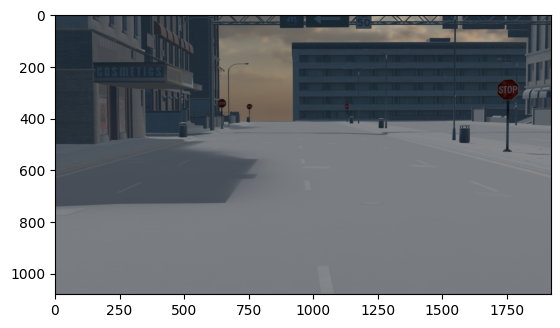

In [157]:
ii = cv2.imread(f"./models/data/dataset/dataset_roboflow/train/images/{i_path[180]}")
ii = cv2.cvtColor(ii, cv2.COLOR_BGR2RGB)
plt.imshow(ii)

output_image = ii.copy()

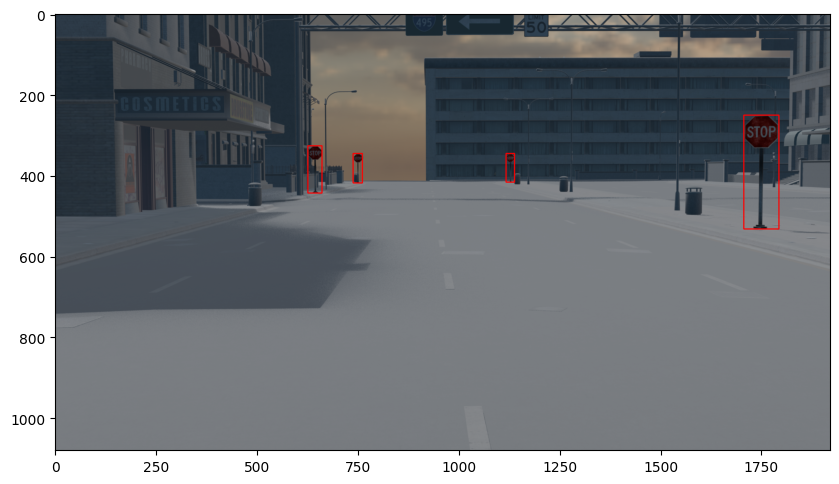

In [158]:
for i in range(len(list_of_labels)):
  id = list_of_labels[i]
  x_new = int(id[1]*output_image.shape[1])
  y_new = int(id[2]*output_image.shape[0])
  w_new = int(id[3]*output_image.shape[1])
  h_new = int(id[4]*output_image.shape[0])
  image2 = cv2.rectangle(output_image, (int(x_new-w_new/2), int(y_new-h_new/2)), (int(x_new+w_new/2), int(y_new+h_new/2)), (255, 0, 0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(image2)